All configuration and model checks passed.
[0.    0.025 0.05  0.075 0.1  ]
Database generation complete


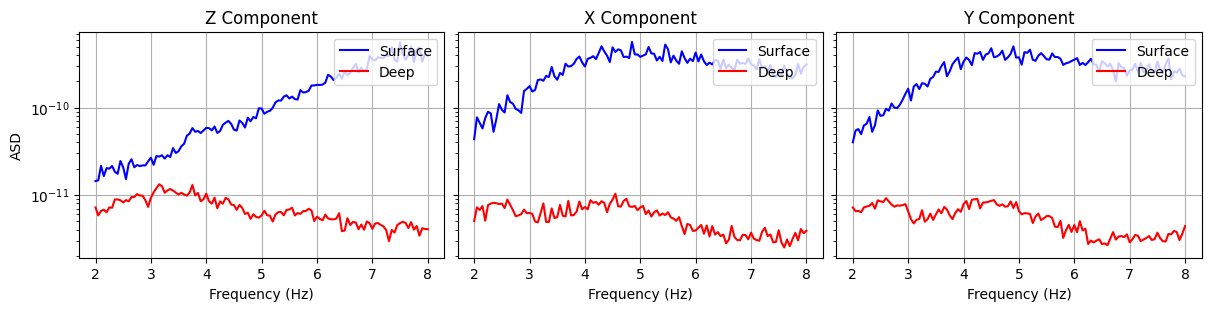

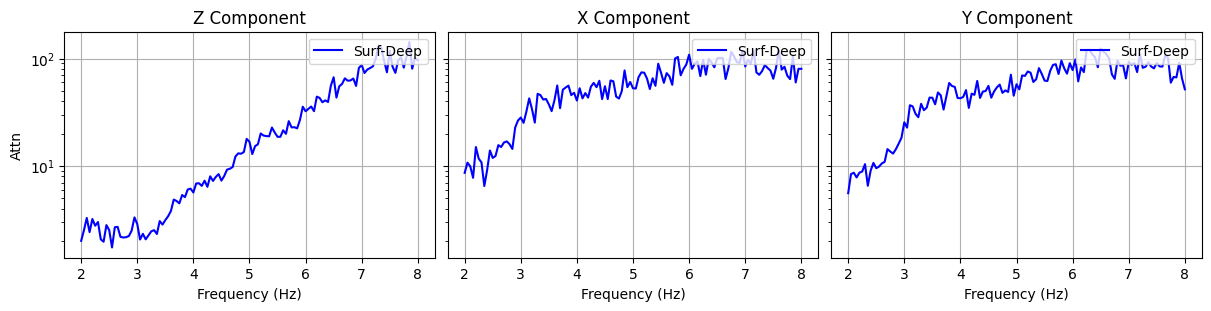

In [5]:
import numpy as np
from scipy.io import savemat
from scipy.io import loadmat
from pysurf96 import surf96
from modules import configLoader
from modules import validateInputs
from modules import createDB
from modules import simDisp
from modules import gfLoader
from modules import plotUtils
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import subprocess
import os
import glob
import shutil
import time
from concurrent.futures import ProcessPoolExecutor, as_completed

def main():
    # load the configuration, some default values to create the structure
    config = configLoader.load_config("configParse.ini");
    validateInputs.validateInputs(config);
    # green's function components to be generated and used for the vertical and horizontal force
    components = ['fh-2.tz', 'fh-2.tr', 'fh-2.tt', 'fz-2.tz', 'fz-2.tr']
    
    # placeholder for many subsurface models to be generated
    vP = np.array((1000,3000.0, 4500.0, 5000.0, 5800.0, 6000.0))
    vS = np.array((500.0,1500.0,2500.0,3000.0,3360.0,3750.0))
    thickness = np.array((30.0,90.0,180.0,700.0,4000.0,0.0))
    rho = np.array((1743.0,2294.3,2539.0,2606.8,2720.0, 2800.0))
    qP = np.array((100,250,400,600,900,1200))
    qS = np.array((50,125,200,300,450,600))

    # generate this from the size of vP, vS, thickness, rho, qp,qs
    nModels = 1; # here we test the workflow with one model
    
    # number of realizations to be done
    nRea = 20; # can be increased, but going beyond 20 is not necessary
    nSrc = 100 # number of sources per realization
    xMin = -2000; xMax = 2000; yMin = -2000; yMax = 2000 # units in meters
    srcDistri = 'internal' # this is the best scenario, where you have sources everywhere

    # the two depths at which you want to compute the displacement field
    zList = [0.0, 250.0];
    
    # generate the frequency grid for the computation
    freqOut, idxFreq, df_native = simDisp.getFreqGrid(config.tMax, config.nSamp, config.fMin, config.fMax, config.df);
    nFreq = len(freqOut)
    
    # generate the source properties, fixed for all subsurface models explored
    # create containers
    xSrc = np.zeros((nSrc,nRea)); ySrc = np.zeros((nSrc,nRea))
    azSrc = np.zeros((nSrc,nRea)); phiSrc = np.zeros((nSrc,nFreq,nRea));
    ampSrc = np.zeros((nSrc,nFreq,nRea));
    # loop and populate source properties
    for reaNo in range(0,nRea):
        # get the source distribution
        xSrc[:,reaNo], ySrc[:,reaNo], azSrc[:,reaNo], phiSrc[:,:,reaNo], ampSrc[:,:,reaNo] =  simDisp.genAmbSrc(nSrc , mode = srcDistri, R1 = None, R2 = None, xMin=xMin,
                                                               xMax=xMax, yMin=yMin, yMax=yMax, randomPhase=True,
                                                               freqDependent=True, nFreq=nFreq)
    # now loop across models

    for nMod in range(0,nModels):
        # first repopulate the subsurface model values
        config.vP = vP;
        config.vS = vS;
        config.rho = rho;
        config.qP = qP;
        config.qS = qS;

        #splitAll = createDB.createFinalInputsTD(config, zList);

        #results = createDB.runMultiQseis(splitAll, config.inputPath, config.qseisExe, nWorkers = config.cpuCoresQseis)
        print("Database generation complete")

        splitFileName = os.path.join(config.inputPath,'splitAll.mat');
        splitMat = loadmat(splitFileName);
        splitAll = splitMat['splitAll'];
        
        # within outDispRea create a folder for storing displacement results
        modelFoldName = f"Model{nMod}"
        outDispRea = os.path.join(config.outDispPathRea, modelFoldName);
        if os.path.exists(outDispRea):
            shutil.rmtree(outDispRea)
        # recreate folder
        os.makedirs(outDispRea)
        
        for reaNo in range(0,nRea):
            simDisp.getSurfDeepDispPerRea(zList, xSrc[:,reaNo], ySrc[:,reaNo], azSrc[:,reaNo], phiSrc[:,:,reaNo],
                                          ampSrc[:,:,reaNo], config.xMaxGF, splitAll, config.fMin, config.fMax,
                                          outDispRea, config.inputPath, components, reaNo, idxFreq = idxFreq,
                                          freqOut=freqOut,nCPU=config.cpuCoresDisp)

        # read the saved surface and deep displacements
        dispPointAllRea, attnAllRea, freqDisp = simDisp.assembleSurfDeepDispAllRea(outDispRea, zList, freqOut, nRea)
        
        # remove displacements saved per realization and temporary folders
        npzFiles = os.path.join(outDispRea, "surfDeepDispRea*.npz")

        for f in glob.glob(npzFiles):
            os.remove(f)

        # --- delete folders ---
        depthFold = os.path.join(outDispRea, "Depth*")
        for folder in glob.glob(depthFold):
            if os.path.isdir(folder):
                shutil.rmtree(folder)
                
        # plot while using ipynb scripts
        figASD, axASD = plotUtils.plotPSDDeepSurfMulti(freqOut, dispPointAllRea[:,:,0], 'Surface', 'b', fig=None, axs=None, 
                                         quantity="ASD")
        figASD, axASD = plotUtils.plotPSDDeepSurfMulti(freqOut, dispPointAllRea[:,:,1], 'Deep', 'r', fig=figASD, axs=axASD, 
                                         quantity="ASD")

        figAttn, axAttn = plotUtils.plotPSDDeepSurfMulti(freqOut, attnAllRea, 'Surf-Deep', 'b', fig=None, axs=None, 
                                         quantity="Attn")
        

if __name__ == "__main__":
    main()